# Open Pose Step-by-Step 

Openpose is a bottom-up approach for realtime multi-person pose estimation invented by Carnegie Mellon University. It is an important task to be used in different domains including action recognition, motion capture, sports, etc. In contrast to top-down approaches by which the runtime is proportional to the number of people, the bottom-up approach decouples the runtime complexity for the number of people, allowing high accuracy with realtime performance. The details can be found from their [CVPR'17 paper](https://arxiv.org/abs/1611.08050).[The official github repo](https://github.com/ZheC/Realtime_Multi-Person_Pose_Estimation) is available for reference as well. 

This tutorial is designed to provide an explaination on how to step-by-step build the system using Pytorch framework. The overall pipeline involves different fields including deep learning, calculus, graph theory and set theory. Let's go through each stage from an input image until the skeletons of the people are created and find out the magic behind: 

<img src="images/pipeline.png"  width="800" style="float: left;">

## Net Prediction 

The deep learning neural net is responsible for predicting part confidence map (heatmap) and part affinity field (PAF) maps from the input image. The architecture of this featured two-branch multi-stage CNN is presented below:

<img src="images/CNN.png"  width="600" style="float: left;">

The set of 2D confidence maps (top branch) represents the body part locations. There are totally 19 confidence maps with 18 of them are body parts and the 19th is the background. The set of part affinity field maps (bottom brahcn) encode the 2D vectors for a given limb. There are 38 PAF maps containing the x and y directions for a given limb (totally 19 limbs). Below figure illustrates the skeleton of the indeces of parts and paris on the COCO dataset. The confidence map and PAF map are indexed correspondingly  

<img src="images/skeleton.jpg"  width="400" style="float: left;">

The image will initially go through a convolutional network to generate a set of feature maps. The feature maps will then fill into refinement stages which is featured as an iterative prediction architecture. Each stage could produce a set of detection confidence maps and a set of part affinity fields. The predictions are refined with more stages. 

The original implementation from CMU uses VGG-19 backbone as the feature exractor, then performs initial estimation of heatmaps and pafs, after that 5 refinement stages are performed. [Daniil Osokin](https://arxiv.org/pdf/1811.12004.pdf) proposed a light weight version of OpenPose. He applied mobilenet as the backbone and single prediction branch for the refinement stages. The proposed network has only 4.1M parameters and 9 billions GFLOPS complexity with decent quality and robustness. The [code and model](https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch) are available at Github. In this repo, we provide both CMU and lightweight version of networks.

## Multi-person Parsing

The heatmaps provide the confidence of each part on the image. We need to transform confidence into certainty. We will apply an algorithm to find the local maximum with its value higher than the predefined threshold. 

After we obtain the discrete set of part candidate locations, we will need to connect them to form pairs which is a well-known problem in graph theory - assignment problem. That is the beauty of PAF. The line integral over the corresponding PAF is computed along the line segment connecting the candidate part locations. In other words, we hold a score for every possible connection to evaluate the confidence in their association. In the code, the line integral is approximated by sampling and summing uniformly-spaced values. 

<img src="images/Parsing.png"  width="200" style="float: left;">

## Merging 

The final step is to transform these detected connections into the final skeletons. The logic is very straight forward. The connections that share the same part detection candidates are assembled together. Taht is, if two connections share the same part, there are merged to the same person.

Finally, a collection of human sets are built, where each human is a set of parts, each part contains its index, its relative coordinates and its score.

## Let's rock the code

In [1]:
import sys
sys.path.insert(0, 'python')
import cv2
from model import bodypose_model
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import copy
import time
import torch
import numpy as np
import torchvision
from PIL import Image, ImageDraw
import matplotlib.cm as cm
import math

## Import model 

CMU's original Neural Net with pre-trained weight is loaded here

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = bodypose_model().to(device)
model.load_state_dict(torch.load('weights/bodypose_model', map_location=lambda storage, loc: storage))
model.eval()

bodypose_model(
  (model0): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_2): ReLU(inplace=True)
    (pool1_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_2): ReLU(inplace=True)
    (pool2_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=

## Import Image 

In [3]:
test_image = 'images/ski.jpg'
since = time.time()
oriImg = cv2.imread(test_image)
oriImg.shape

(674, 712, 3)

## Identify some hyperparameters

* scale_search functions to induce series of scaled images to model, allow more accurate results with sacifice of inference time
* boxsize is the baseline image height to be scaled 
* stride: openpose model has stride = 8 for VGG backbone to obtain heat and PAF feature map
* padValue: the input image is desired to be divisible by 8. Therefore pad 128 value if necessary 
* thre1: identify the peak value and cooridnate from heatmap if > thre1
* thre2: identify true connection if score of line integral over corresponding PAF > thre2
* heatmap_avg: 19 channels: 18 parts and 1 background 
* paf_avg: 38 channels representing 19 connections with x, y vector for each 

In [4]:
scale_search = [0.5, 1.0, 1.5, 2.0]
boxsize = 368
stride = 8
padValue = 128
thre1 = 0.1 # heatmap peak identifier threshold 
thre2 = 0.05 # connection and paf score threshold 
multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

## Net Inference 

* rescale padded image and preprocess it for network input(image is inputed as BGR)
* The predicted heatmap and PAF maps are resized via stride (x8), remove padding and resizing via scale 
* average heatmap and PAF maps for various sized images 

It should be noted that orignial CMU code has heatmap and PAF map resized to orignial image. [Daniil Osokin](https://arxiv.org/pdf/1811.12004.pdf) has found that is not necessary. With upsample factor 8, the accuracy stays the same. This way will enable a faster post-processing. This repo here adopted Daniil's approach to speed up the model inference time.

In [5]:
def padRightDownCorner(img, stride, padValue):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0 # up
    pad[1] = 0 # left
    pad[2] = 0 if (h % stride == 0) else stride - (h % stride) # down
    pad[3] = 0 if (w % stride == 0) else stride - (w % stride) # right

    img_padded = np.pad(img, ((pad[0], pad[2]), (pad[1], pad[3]), (0, 0)), 'constant', constant_values=padValue) 

    return img_padded, pad

In [6]:
for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = padRightDownCorner(imageToTest, stride, padValue)
    # pad right and down corner to make sure image size is divisible by 8
    im = np.transpose(np.float32(imageToTest_padded), (2, 0, 1)) / 256 - 0.5
    im = np.ascontiguousarray(im)
    data = torch.from_numpy(im).float().unsqueeze(0).to(device)
    
    with torch.no_grad():
        Mconv7_stage6_L1, Mconv7_stage6_L2 = model(data)
        Mconv7_stage6_L1 = Mconv7_stage6_L1.cpu().numpy()
        Mconv7_stage6_L2 = Mconv7_stage6_L2.cpu().numpy()         
        
    # extract outputs, resize, and remove padding
    heatmap = np.transpose(np.squeeze(Mconv7_stage6_L2), (1, 2, 0))  # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    paf = np.transpose(np.squeeze(Mconv7_stage6_L1), (1, 2, 0))  # output 0 is PAFs
    paf = cv2.resize(paf, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    heatmap_avg += heatmap / len(multiplier)
    paf_avg += + paf / len(multiplier)

print(heatmap_avg.shape, paf_avg.shape)

(674, 712, 19) (674, 712, 38)


## Visualize 

* visualize the model predicted heatmap and paf on test image
* Heat map indices to find each limb. Eg: limb_type=0 is Nose
* PAF indices containing the x and y cooridnates of the PAF for a given limb Eg: limb_type =0 is Neck to Lefthip 

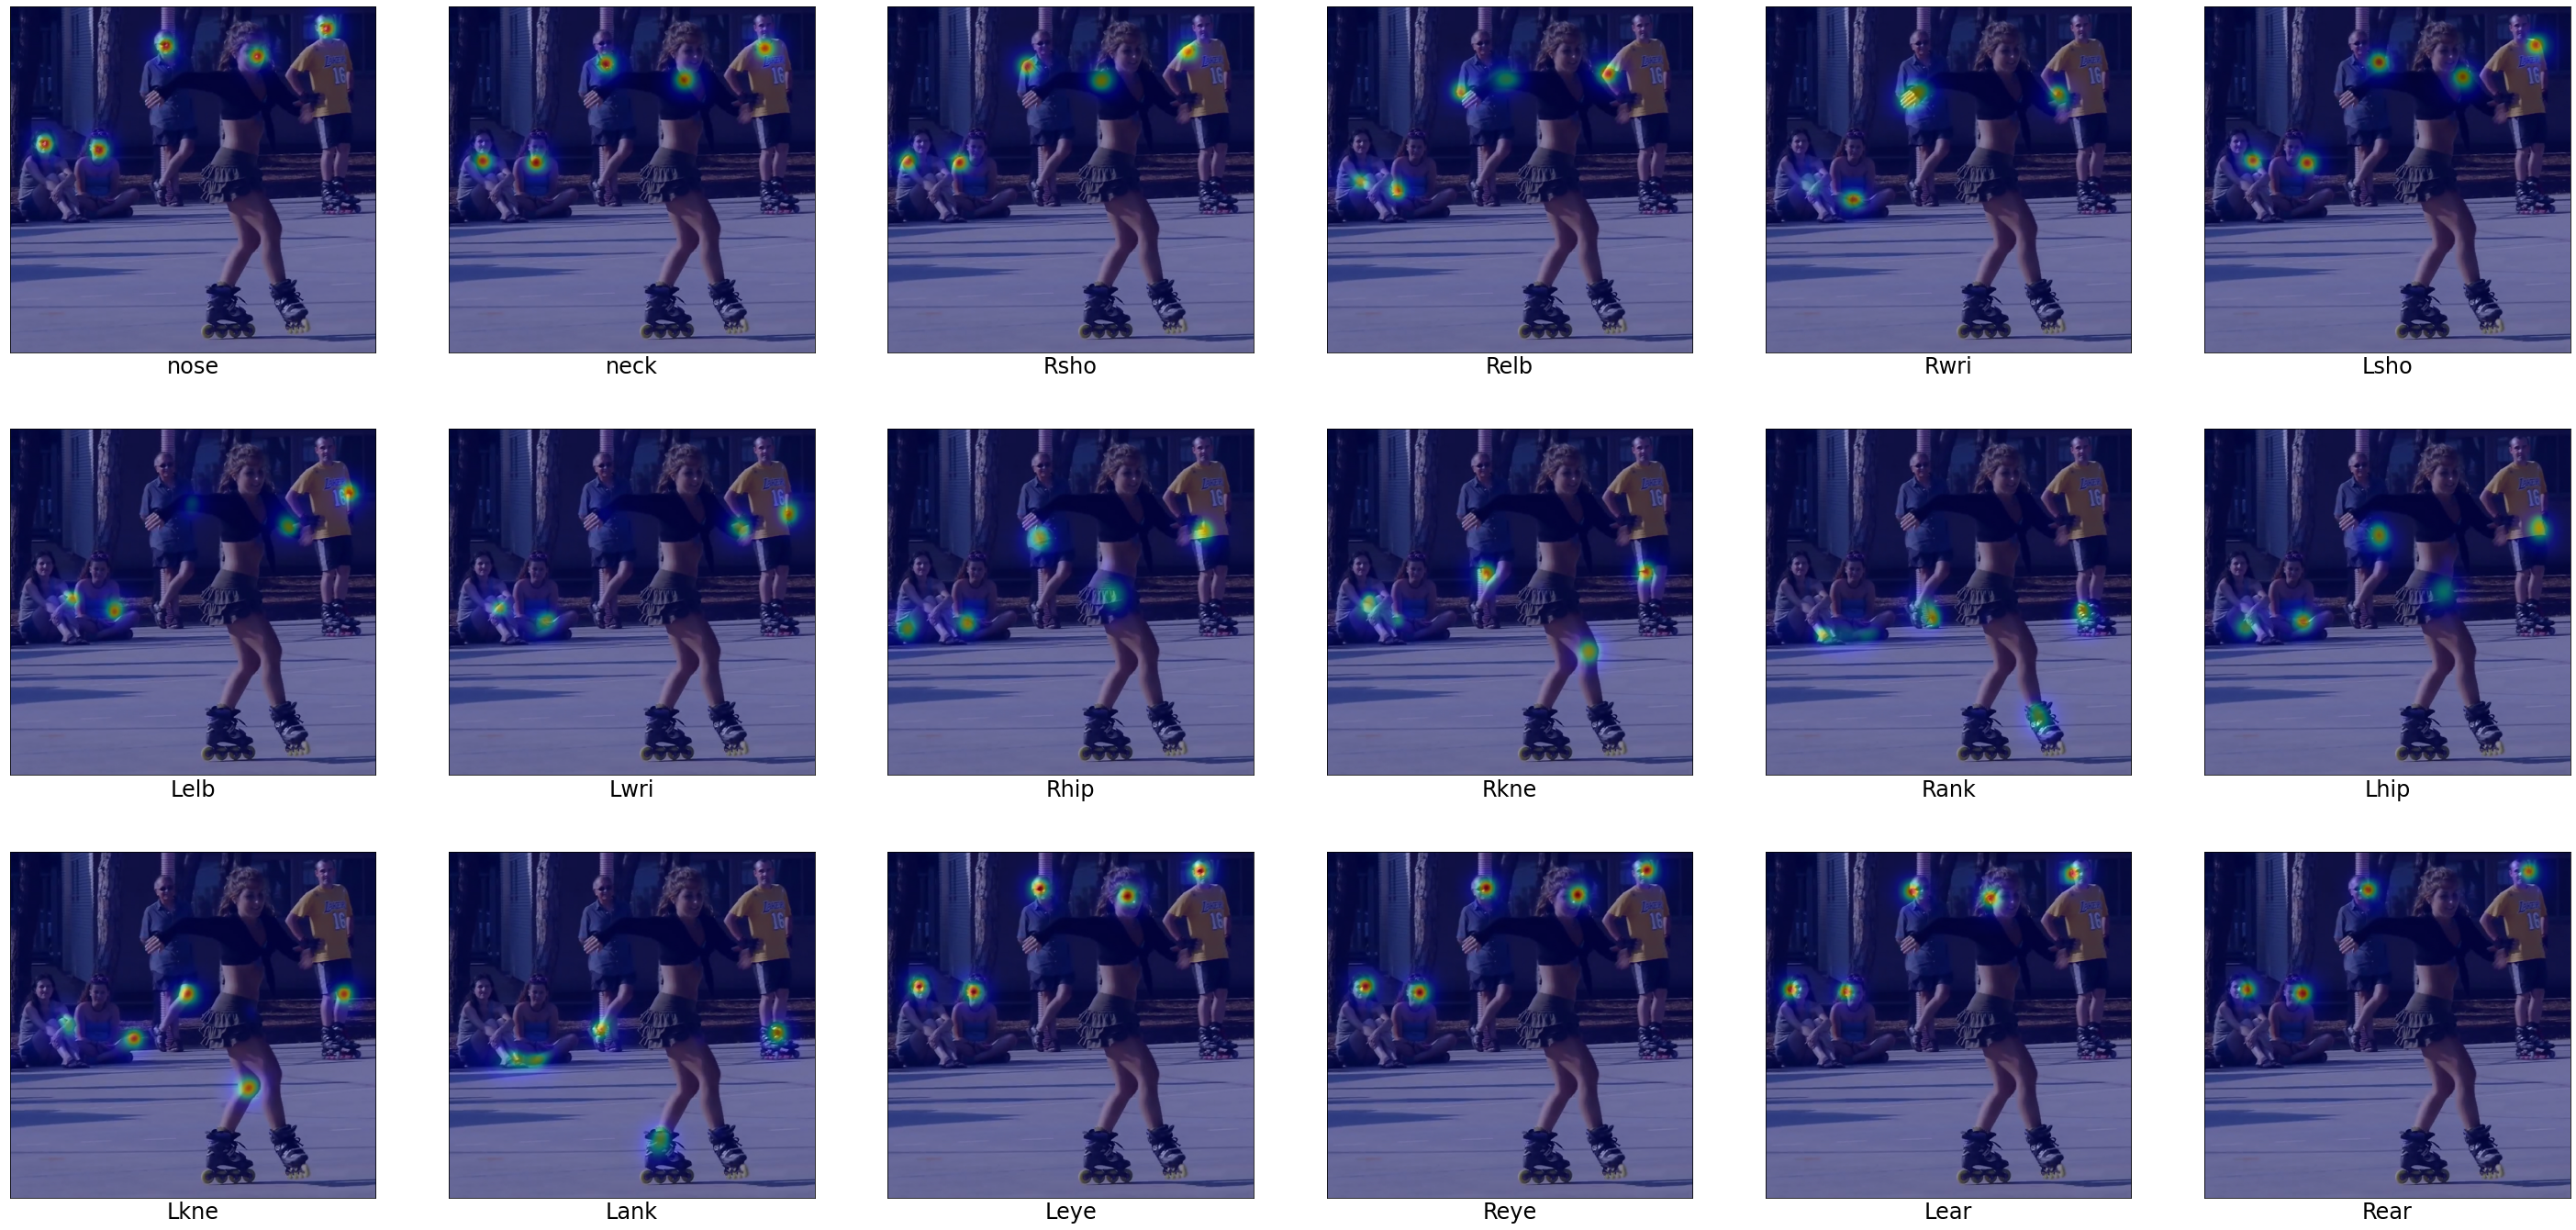

In [7]:
def visualize_heatmap(image_path, heatmap, label):
    plt.figure(figsize=(50,24))
    max_value = np.max(heatmap)
    min_value = np.min(heatmap)
    img_list = []
    im = Image.open(image_path)
    for i in range(18):
        vis_img = (heatmap[:, :, i]-min_value)/max_value
        vis_img = Image.fromarray(np.uint8(cm.jet(vis_img) * 255))
        vis_img = vis_img.convert('RGB') 
        vis_img = Image.blend(im, vis_img, 0.4)
        vis_img = np.array(vis_img)
        plt.subplot(3,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(vis_img)
        plt.xlabel(label[i], fontsize=24)
        
    plt.show()

label = ['nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb', 'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 'Leye', 'Reye', 'Lear', 'Rear', 'pt19']    
visualize_heatmap(test_image, heatmap_avg, label)

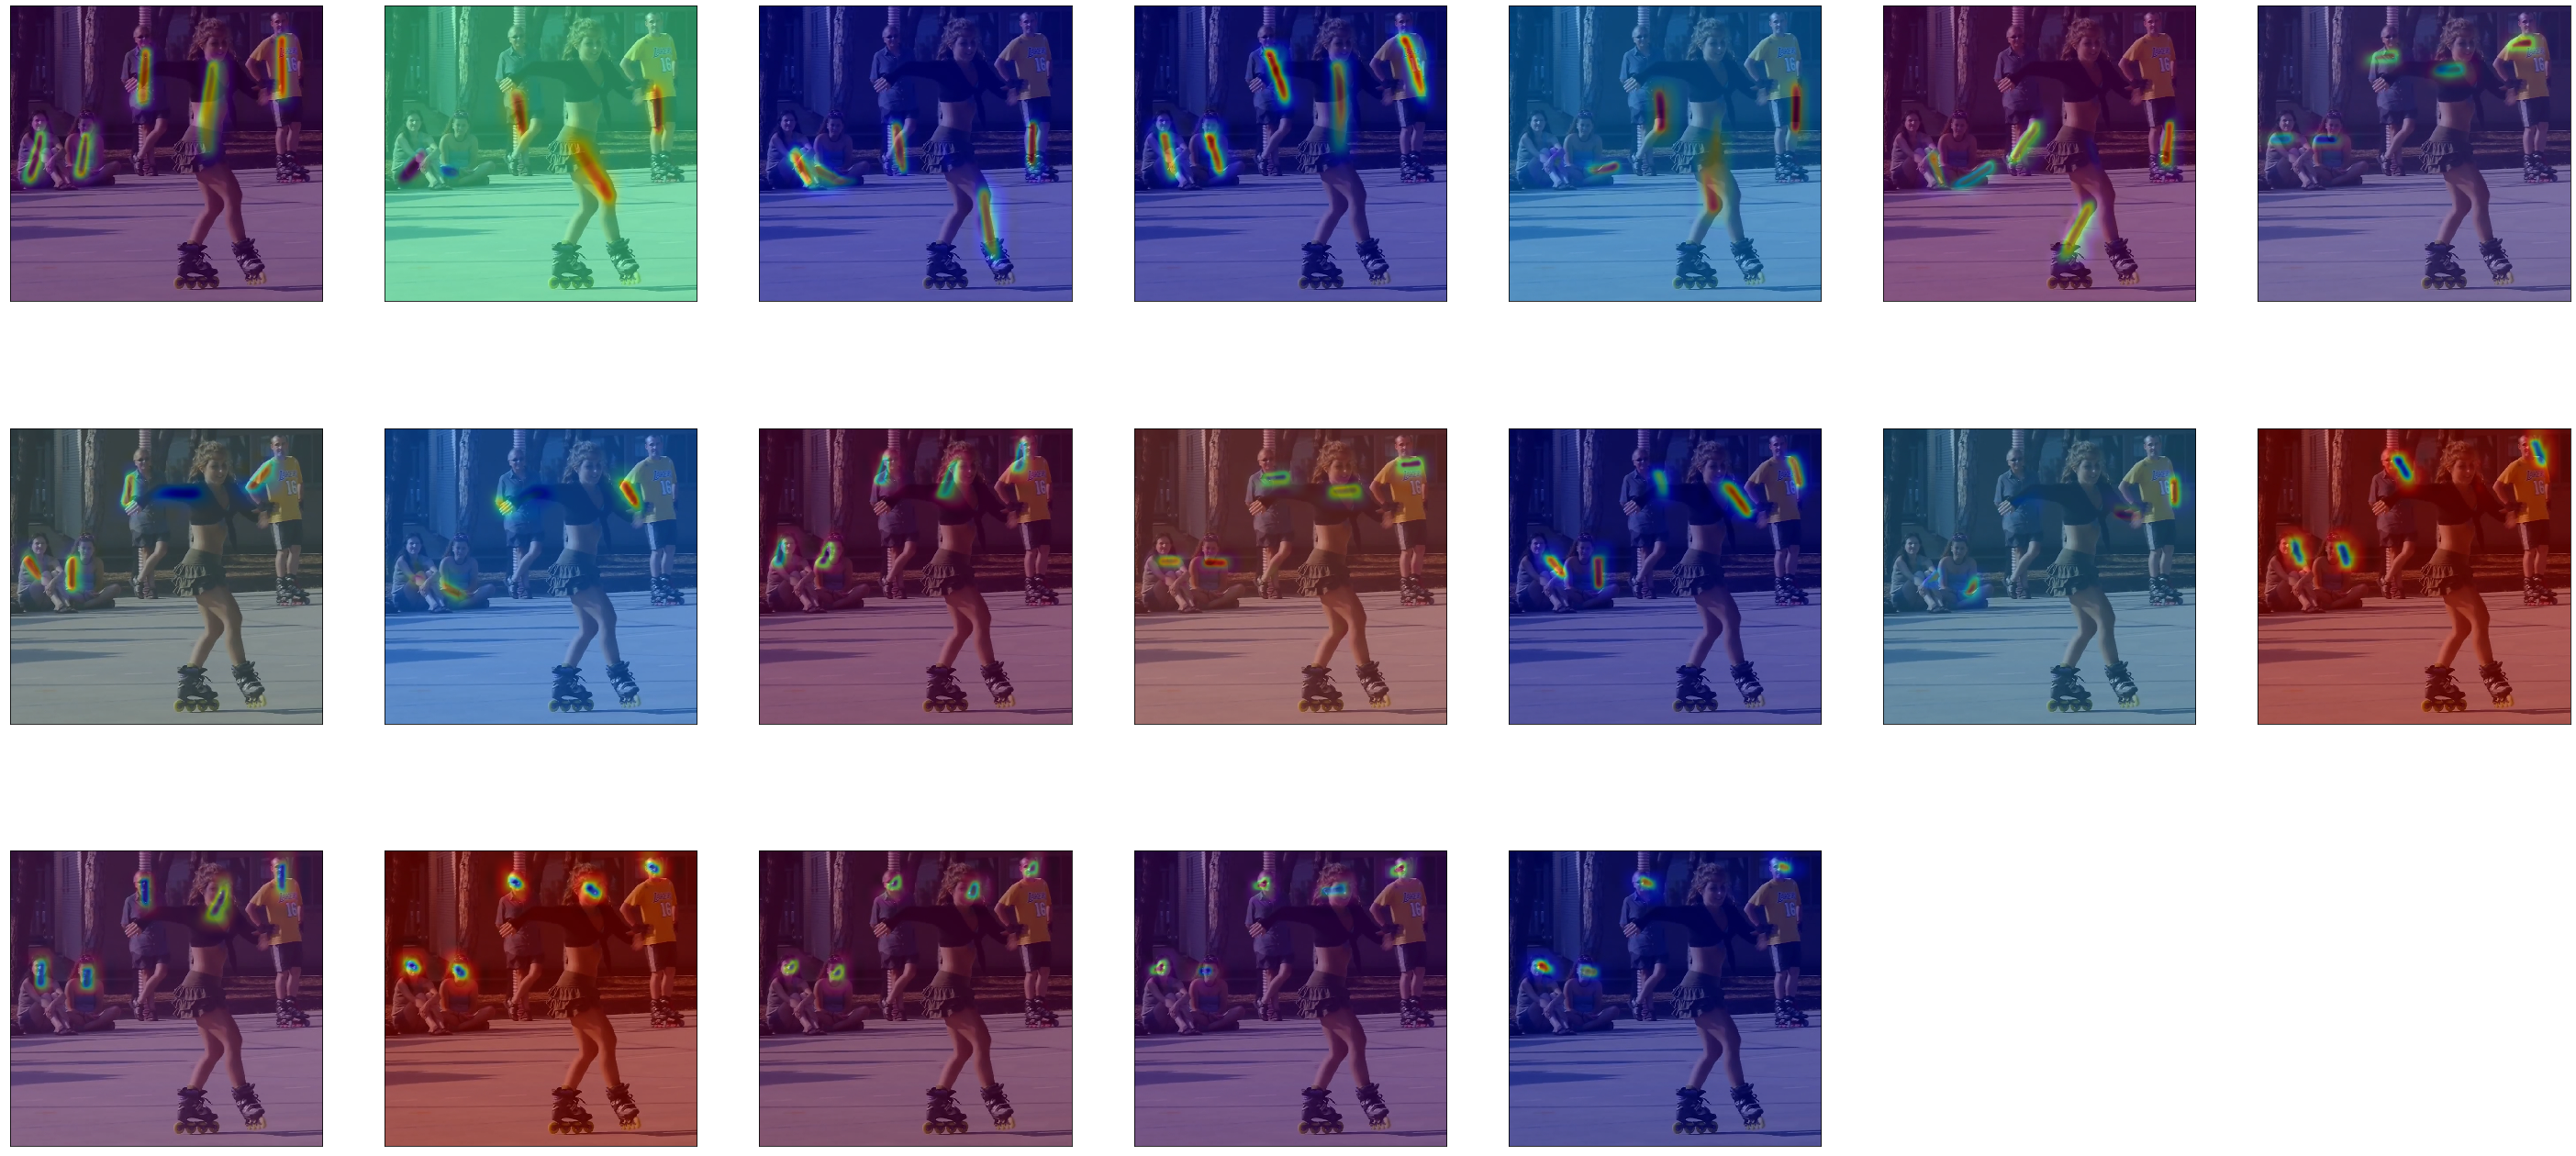

In [8]:
def visualize_paf(image_path, paf):
    plt.figure(figsize=(50,24))
    max_value = np.max(paf)
    min_value = np.min(paf)
    img_list = []
    im = plt.imread(test_image)
    for i in range(19):
        vis_img_x = (paf[:, :, i*2]-min_value)/max_value
        vis_img_y = (paf[:, :, i*2+1]-min_value)/max_value    
        plt.subplot(3,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(im, interpolation='nearest')
        plt.imshow(vis_img_x, cmap=plt.cm.jet, alpha=0.3)
        plt.imshow(vis_img_y, cmap=plt.cm.jet, alpha=0.3)
        
    plt.show()
    
visualize_paf(test_image, paf_avg)

## Retrieve the Peak Information from Heatmap

Below code is intended to retrieve peak location (transform confidence into certainty), score and unique id for each part. 'all_peaks' returns a list of 18 parts. For each part, there are several detected candidates with each row containing: x, y, score, id 

* use gaussian filter to preprocess the heatmap 
* find the local peak with window size = 1 and the corresponding score is higher than thre1
* each detection is assiged with a unique ID

In [8]:
all_peaks = []
peak_counter = 0

for part in range(18):
    map_ori = heatmap_avg[:, :, part]
    one_heatmap = gaussian_filter(map_ori, sigma=3) # smooth the data
    map_left = np.zeros(one_heatmap.shape)
    map_left[1:, :] = one_heatmap[:-1, :]
    map_right = np.zeros(one_heatmap.shape)
    map_right[:-1, :] = one_heatmap[1:, :]
    map_up = np.zeros(one_heatmap.shape)
    map_up[:, 1:] = one_heatmap[:, :-1]
    map_down = np.zeros(one_heatmap.shape)
    map_down[:, :-1] = one_heatmap[:, 1:]

    peaks_binary = np.logical_and.reduce(
        (one_heatmap >= map_left, one_heatmap >= map_right, one_heatmap >= map_up, one_heatmap >= map_down, one_heatmap > thre1))
    # find the peak of surrounding with window size = 1 and above threshold
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
    peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
    peak_id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (peak_id[i],) for i in range(len(peak_id))]
    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

print(len(all_peaks))
print(all_peaks[0])

18
[(616, 44, 0.9328415095806122, 0), (303, 78, 0.9390939027070999, 1), (481, 98, 0.9126663208007812, 2), (68, 268, 0.9364415109157562, 3), (173, 280, 0.9533376693725586, 4)]


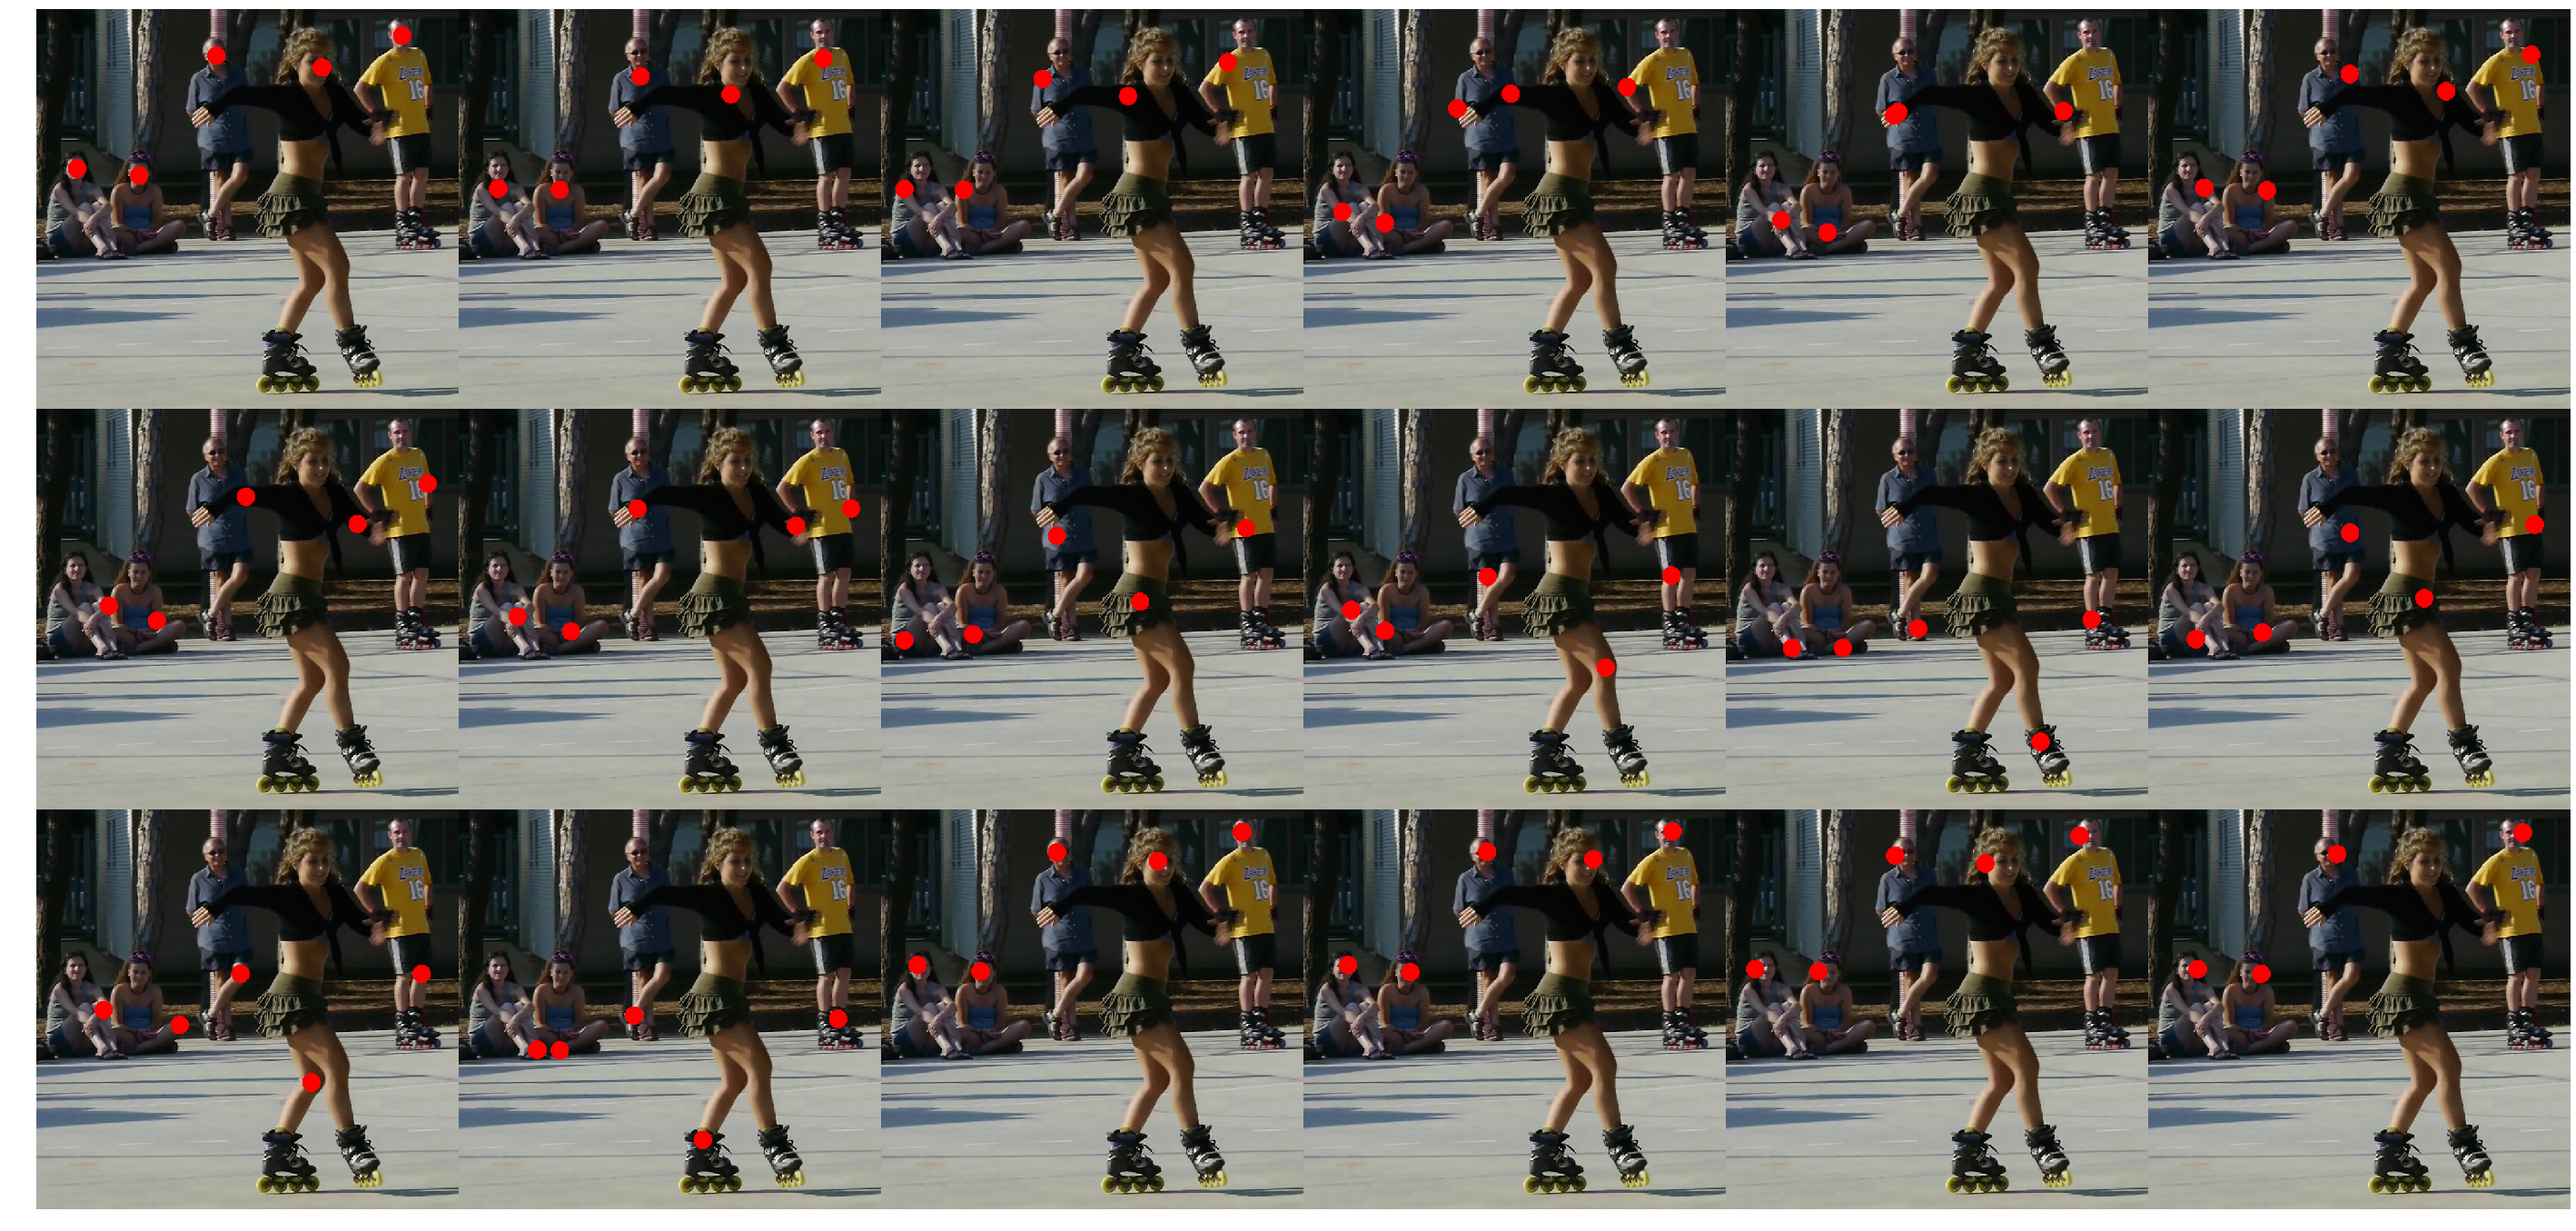

In [10]:
def visualize_dot(image_path, all_peaks):
    plt.figure(figsize=(50,50))
    img_list = []
    for i in range(len(all_peaks)):
        im = Image.open(image_path)
        draw = ImageDraw.Draw(im)
        for j in range(len(all_peaks[i])):
            draw.ellipse([(all_peaks[i][j][0] - 15.0, all_peaks[i][j][1] - 15.0), 
                          (all_peaks[i][j][0] + 15.0, all_peaks[i][j][1] + 15.0)], fill='red')
        vis_img = np.array(im)
        img_list.append(np.transpose(vis_img, (2, 0, 1)))
    img_list = torchvision.utils.make_grid(torch.from_numpy(np.array(img_list)), nrow=6, padding=0)
    plt.imshow(np.transpose(img_list.numpy(), (1, 2, 0))) 
    plt.axis('off')
    
visualize_dot(test_image, all_peaks)

## Multi-Person Parsing 

We have found the candidates for each of the body parts, the next step is to connect them to form pairs. The below code defines the parts and pairs connection squence. Here are totally 19 connections 

part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, background]

It should be noted that below schedule starts from 1 as nose (while coco dataset starts from 0 as nose). The PAF index ranges from 19 to 56 (totally 38). The number 19 is the same as 0 from coco dataset.

In [10]:
limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18], [3, 17], [6, 18]]
# the middle joints heatmap correpondence
mapIdx = [[31, 32], [39, 40], [33, 34], [35, 36], [41, 42], [43, 44], [19, 20], [21, 22], \
          [23, 24], [25, 26], [27, 28], [29, 30], [47, 48], [49, 50], [53, 54], [51, 52], \
          [55, 56], [37, 38], [45, 46]]

### The logic is described as:
* for each pair from mapIdx, find all candidate part A and B from all_peaks
* calculate the unit vector for all possible connections from candidate part A and B -- vec 
* divide the connection line between A and B into 10 uniform sections and find out the corresponding coordinates.   
  Retrieve the PAF x and y values for each cooridnate  -- vec_x, vec_y
* multiply (vec_x, vec_y) with vec to obtain the score_midpts (array(10,)
* calculate the average score of score_midpts with bonus if connection norm is lower than half test image height --score_with_dist_prior
* set up 2 criterion to filter the connections: criterion1: if > 8 / 10 score_midpts is higher than thre2
  criterion2: score_with_dist_prior > 0
* return a list of connection_all with length 19. For each element of connection_all, there are multiply connections with each row: ID_A, ID_B, score_with_dist_prior, i, j (i, j are the local indexes of each part from all peaks)

In [11]:
connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:, :, [x - 19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0] - 1]  # all candidate part A from all_peaks
    candB = all_peaks[limbSeq[k][1] - 1] # all candidate part B from all_peaks
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if (nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                vec = np.divide(vec, norm)

                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                    np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts) / len(score_midpts) + min(
                    0.5 * oriImg.shape[0] / norm - 1, 0)
                criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append(
                        [i, j, score_with_dist_prior, score_with_dist_prior + candA[i][2] + candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0, 5))
        for c in range(len(connection_candidate)):
            i, j, s = connection_candidate[c][0:3]
            if (i not in connection[:, 3] and j not in connection[:, 4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if (len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

print(len(connection_all))
print(connection_all[0])

19
[[ 9.         14.          1.01906039  4.          4.        ]
 [ 5.         10.          0.97120537  0.          0.        ]
 [ 8.         13.          0.97039057  3.          3.        ]
 [ 6.         11.          0.94356457  1.          1.        ]
 [ 7.         12.          0.84906815  2.          2.        ]]


## Merge 

The final step is to transform these detected connections into the final skeletons. The below code returns subset: n*20 array --- n is the number of person. For each person, 0-17 is the ID from 'all_peaks' aligned with the part order, 18 is the total score, 19 is the total parts found,  

In [12]:
subset = -1 * np.ones((0, 20))
# build up numpy array for peaks: x, y, score, id
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:, 0]
        partBs = connection_all[k][:, 1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])):  # = 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)):  # 1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1

            if found == 1:
                j = subset_idx[0]
                if subset[j][indexB] != partBs[i]:
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2:  # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                membership = ((subset[j1] >= 0).astype(int) + (subset[j2] >= 0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0:  # merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else:  # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i, :2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])
# delete some rows of subset which has few parts occur
deleteIdx = []
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
        deleteIdx.append(i)
# subset: n*20 array, 0-17 is the index in candidate, 18 is the total score, 19 is the total parts, n is the number of person 
subset = np.delete(subset, deleteIdx, axis=0)
subset

array([[ 4.        ,  9.        , 14.        , 19.        , 29.        ,
        34.        , 39.        , 44.        , 48.        , 53.        ,
        58.        , 63.        , 68.        , 73.        , 79.        ,
        84.        , 89.        , 93.        , 29.18051238, 18.        ],
       [ 0.        ,  5.        , 10.        , 15.        , 20.        ,
        30.        , 35.        , 41.        , 45.        , 50.        ,
        55.        , 60.        , 66.        , 71.        , 75.        ,
        80.        , 85.        , 90.        , 31.11251001, 18.        ],
       [ 3.        ,  8.        , 13.        , 18.        , 28.        ,
        33.        , 38.        , 43.        , 49.        , 52.        ,
        57.        , 64.        , 67.        , 72.        , 78.        ,
        83.        , 88.        , 92.        , 27.11871512, 18.        ],
       [ 1.        ,  6.        , 11.        , 17.        , 27.        ,
        31.        , 36.        , 40.        , 4

## Visualize 

Let's put together and visualize the final results 

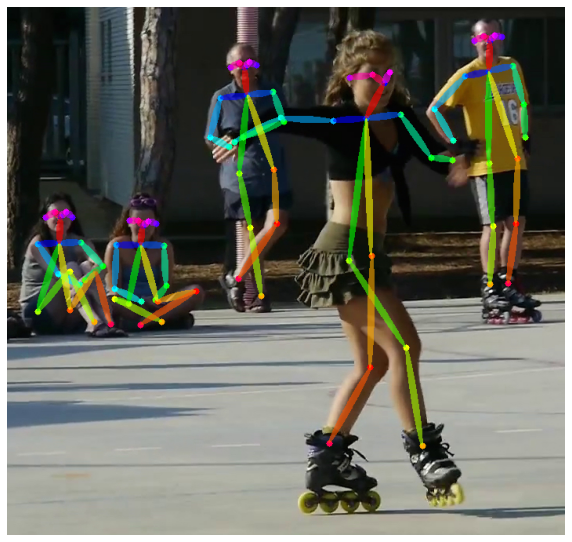

In [13]:
canvas = copy.deepcopy(oriImg)
stickwidth = 4

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

for i in range(18):
    for n in range(len(subset)):
        index = int(subset[n][i])
        if index == -1:
            continue
        x, y = candidate[index][0:2]
        cv2.circle(canvas, (int(x), int(y)), 4, colors[i], thickness=-1)
for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i]) - 1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

plt.figure(figsize=(10,10))        
plt.imshow(canvas[:, :, [2, 1, 0]])
plt.axis('off')
plt.show()

# End 